<a href="https://colab.research.google.com/github/cuducquang/ML_Project/blob/main/task1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


**Import library**

In [2]:
from google.colab import drive
import gdown
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import hashlib
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import numpy as np
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras_tuner import HyperParameters
from tensorflow import keras
import tensorflow as tf
from google.colab import files

**Download Train Dataset**

In [3]:
drive.mount('/content/drive')

# Google Drive file ID (from the shared link)
file_id = "1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e"
file_name = "train_images.zip"
file_path = "/content/" + file_name

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_path, quiet=False)
print(f"Downloaded: {file_path}")

Mounted at /content/drive


Downloading...
From (original): https://drive.google.com/uc?id=1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e
From (redirected): https://drive.google.com/uc?id=1imVvr3Ydu8CdhM-mjEJ0Wc7IiH5wKV5e&confirm=t&uuid=bdc80067-f805-409f-8d49-fc9f3c11e784
To: /content/train_images.zip
100%|██████████| 820M/820M [00:14<00:00, 55.9MB/s]

Downloaded: /content/train_images.zip


**Extract Train Dataset**

In [4]:
!unzip -q $file_path -d /content/extracted_folder

**Plot Distribution Images in Train Dataset**

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


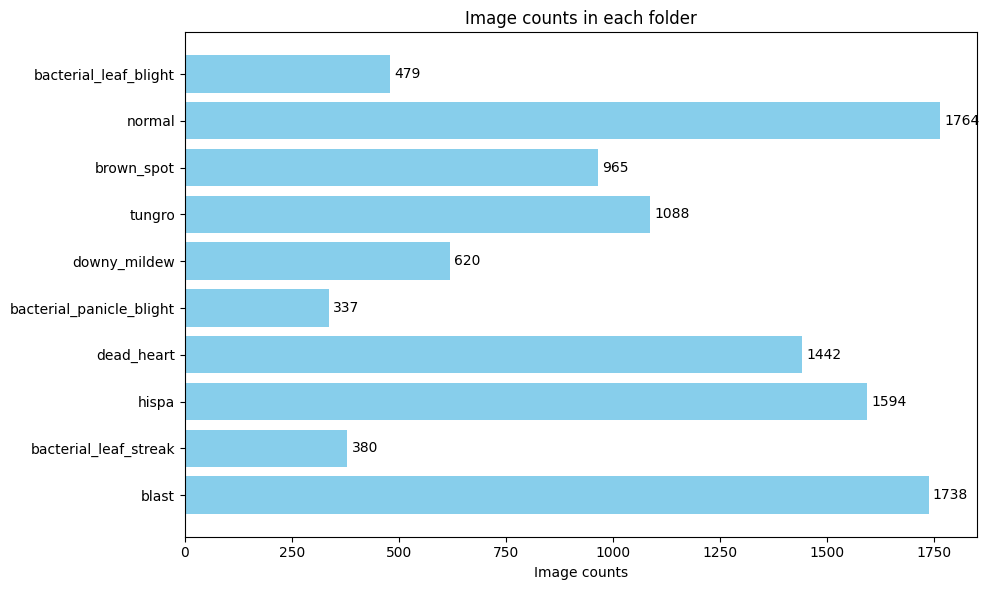

In [5]:
categories = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight',
              'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

dataset_path = "/content/extracted_folder/train_images"

print(categories)

data = []
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        count = len([file for file in os.listdir(label_path) if file.endswith(".jpg")])
        data.append({"label": label, "count": count})

df_counts = pd.DataFrame(data)

plt.figure(figsize=(10,6))
bars = plt.barh(df_counts['label'], df_counts['count'], color='skyblue')

for bar in bars:
    width = bar.get_width()
    plt.text(width + 10, bar.get_y() + bar.get_height()/2,
             str(width), va='center', fontsize=10)

plt.xlabel("Image counts")
plt.title("Image counts in each folder")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Remove Duplicated Images**

In [6]:
from tqdm import tqdm

def compute_md5(file_path):
    with open(file_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def remove_duplicates_in_folder(folder_path):
    seen_hashes = set()
    duplicates = []

    for filename in tqdm(os.listdir(folder_path), desc=f'Checking {folder_path}'):
        file_path = os.path.join(folder_path, filename)

        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        file_hash = compute_md5(file_path)

        if file_hash in seen_hashes:
            duplicates.append(file_path)
        else:
            seen_hashes.add(file_hash)

    for dup_path in duplicates:
        os.remove(dup_path)

    print(f'Removed {len(duplicates)} duplicates in {folder_path}')

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        remove_duplicates_in_folder(category_path)

Checking /content/extracted_folder/train_images/bacterial_leaf_blight: 100%|██████████| 479/479 [00:00<00:00, 5573.56it/s]


Removed 8 duplicates in /content/extracted_folder/train_images/bacterial_leaf_blight


Checking /content/extracted_folder/train_images/normal: 100%|██████████| 1764/1764 [00:00<00:00, 5700.13it/s]


Removed 15 duplicates in /content/extracted_folder/train_images/normal


Checking /content/extracted_folder/train_images/brown_spot: 100%|██████████| 965/965 [00:00<00:00, 5711.83it/s]


Removed 12 duplicates in /content/extracted_folder/train_images/brown_spot


Checking /content/extracted_folder/train_images/tungro: 100%|██████████| 1088/1088 [00:00<00:00, 5539.08it/s]


Removed 8 duplicates in /content/extracted_folder/train_images/tungro


Checking /content/extracted_folder/train_images/downy_mildew: 100%|██████████| 620/620 [00:00<00:00, 5806.51it/s]


Removed 2 duplicates in /content/extracted_folder/train_images/downy_mildew


Checking /content/extracted_folder/train_images/bacterial_panicle_blight: 100%|██████████| 337/337 [00:00<00:00, 6707.26it/s]


Removed 1 duplicates in /content/extracted_folder/train_images/bacterial_panicle_blight


Checking /content/extracted_folder/train_images/dead_heart: 100%|██████████| 1442/1442 [00:00<00:00, 5919.43it/s]


Removed 13 duplicates in /content/extracted_folder/train_images/dead_heart


Checking /content/extracted_folder/train_images/hispa: 100%|██████████| 1594/1594 [00:00<00:00, 6058.79it/s]


Removed 5 duplicates in /content/extracted_folder/train_images/hispa


Checking /content/extracted_folder/train_images/bacterial_leaf_streak: 100%|██████████| 380/380 [00:00<00:00, 5539.27it/s]


Removed 0 duplicates in /content/extracted_folder/train_images/bacterial_leaf_streak


Checking /content/extracted_folder/train_images/blast: 100%|██████████| 1738/1738 [00:00<00:00, 6020.32it/s]

Removed 10 duplicates in /content/extracted_folder/train_images/blast


**Split Train & Validation Dataset**

In [7]:
def split_train_val_with_sklearn(category_path, train_dir, val_dir, test_size=0.2):
    images = [f for f in os.listdir(category_path) if f.lower().endswith('.jpg')]

    train_images, val_images = train_test_split(images, test_size=test_size, random_state=42)

    category_name = os.path.basename(category_path)

    os.makedirs(os.path.join(train_dir, category_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category_name), exist_ok=True)

    for img in train_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(train_dir, category_name, img))

    for img in val_images:
        shutil.copy2(os.path.join(category_path, img), os.path.join(val_dir, category_name, img))

    print(f"{category_name}: {len(train_images)} train, {len(val_images)} val")

train_dir = '/content/data/train'
val_dir = '/content/data/val'

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        split_train_val_with_sklearn(category_path, train_dir, val_dir, test_size=0.2)

bacterial_leaf_blight: 376 train, 95 val
normal: 1399 train, 350 val
brown_spot: 762 train, 191 val
tungro: 864 train, 216 val
downy_mildew: 494 train, 124 val
bacterial_panicle_blight: 268 train, 68 val
dead_heart: 1143 train, 286 val
hispa: 1271 train, 318 val
bacterial_leaf_streak: 304 train, 76 val
blast: 1382 train, 346 val


**Oversampling Data**

In [8]:
def count_images_per_class(dataset_path, ext=".jpg"):
    category_counts = {}
    for category in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, category)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.endswith(ext)]
            category_counts[category] = len(image_files)
    return category_counts

def resample_to_mean(dataset_path, ext=".jpg"):
    random.seed(42)

    counts = count_images_per_class(dataset_path, ext)
    values = list(counts.values())
    mean_sample = math.floor(sum(values) / len(values))

    print(f"[INFO] Mean sample count: {mean_sample}\n")

    for category, count in counts.items():
        if count >= mean_sample:
            print(f"[SKIP] {category}: {count} images (>= mean)")
            continue

        print(f"[RESAMPLE] {category}: {count} → {mean_sample}")
        class_path = os.path.join(dataset_path, category)
        images = [f for f in os.listdir(class_path) if f.endswith(ext)]

        i = 0
        while len([f for f in os.listdir(class_path) if f.endswith(ext)]) < mean_sample:
            img_name = random.choice(images)
            src_path = os.path.join(class_path, img_name)
            new_filename = f"resample_{i}_{img_name}"
            dst_path = os.path.join(class_path, new_filename)
            shutil.copy(src_path, dst_path)
            i += 1

        print(f"[DONE] {category}: now has {mean_sample} images.\n")

resample_to_mean(train_dir)

[INFO] Mean sample count: 826

[RESAMPLE] bacterial_leaf_blight: 376 → 826
[DONE] bacterial_leaf_blight: now has 826 images.

[SKIP] normal: 1399 images (>= mean)
[RESAMPLE] brown_spot: 762 → 826
[DONE] brown_spot: now has 826 images.

[SKIP] tungro: 864 images (>= mean)
[RESAMPLE] downy_mildew: 494 → 826
[DONE] downy_mildew: now has 826 images.

[RESAMPLE] bacterial_panicle_blight: 268 → 826
[DONE] bacterial_panicle_blight: now has 826 images.

[SKIP] dead_heart: 1143 images (>= mean)
[SKIP] hispa: 1271 images (>= mean)
[RESAMPLE] bacterial_leaf_streak: 304 → 826
[DONE] bacterial_leaf_streak: now has 826 images.

[SKIP] blast: 1382 images (>= mean)


**Plot again to see the Data Distribution**

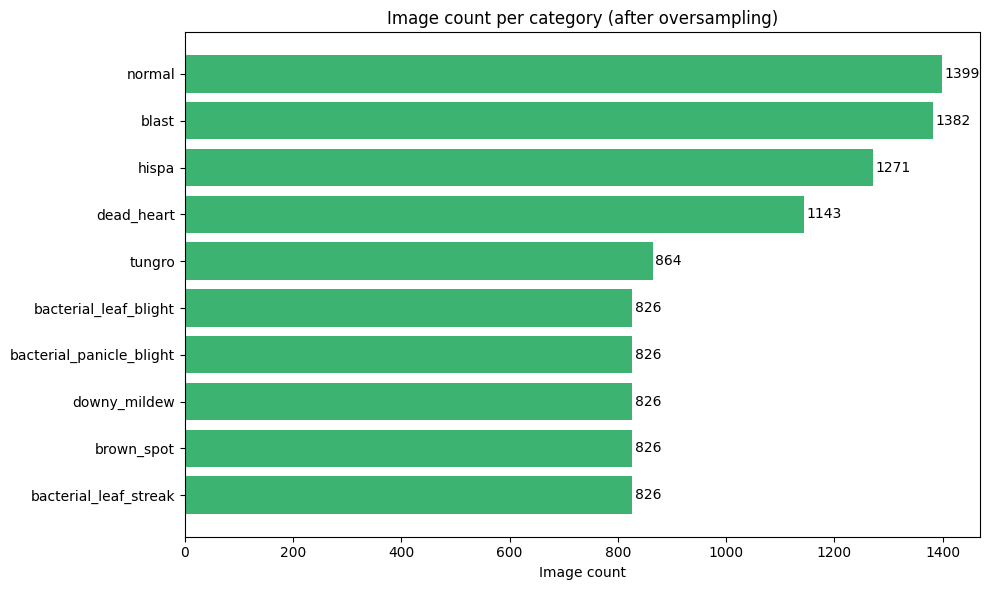

In [9]:
data = []
for label in os.listdir(train_dir):
    label_path = os.path.join(train_dir, label)
    if os.path.isdir(label_path):
        count = len([file for file in os.listdir(label_path) if file.lower().endswith(('.jpg', '.png', '.jpeg'))])
        data.append({"label": label, "count": count})

df_counts = pd.DataFrame(data).sort_values("count", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(df_counts['label'], df_counts['count'], color='mediumseagreen')
plt.xlabel("Image count")
plt.title("Image count per category (after oversampling)")
plt.gca().invert_yaxis()
plt.tight_layout()

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

plt.show()

**Data Argumentation**

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 10189 images belonging to 10 classes.
Found 2070 images belonging to 10 classes.


In [11]:
x_batch, y_batch = next(train_generator)
print("Shape y_batch:", y_batch.shape)
print("Sample y_batch[0]:", y_batch[0])

Shape y_batch: (32, 10)
Sample y_batch[0]: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


**Build Model**

In [12]:
from tensorflow.keras.layers import (BatchNormalization, Activation)

def build_model(hp):
    model = Sequential()

    # Convolutional layers with tunable filter size
    # Block 1
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        padding='same',
        input_shape=(224, 224, 3)
    ))

    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3, 3),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Block 4
    model.add(Conv2D(
        filters=hp.Int('conv4_filters', min_value=128, max_value=512, step=128),
        kernel_size=(3, 3),
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten & Dense
    model.add(Flatten())

    model.add(Dense(
        units=hp.Int('dense1_units', min_value=128, max_value=1024, step=128),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('dense2_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.3, step=0.1)))

    model.add(Dense(10, activation='softmax'))

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4]),
            # beta_1=hp.Float('adam_beta1', min_value=0.8, max_value=0.95, step=0.05),
            # beta_2=hp.Float('adam_beta2', min_value=0.95, max_value=0.999, step=0.01),
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Define the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,  # Reduces bad models quickly
    directory='kt_hyperband',
    project_name='rice_diseased_tuning'
)


# Display the search space
tuner.search_space_summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Search space summary
Default search space size: 9
conv1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
conv3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv4_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
dense1_units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 128, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value

**Fine-tune Search**

In [13]:
tuner.search(
    train_generator,  # Training dataset
    validation_data=val_generator,  # Validation dataset
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparam eters: {best_hps.values}")

Trial 18 Complete [00h 31m 19s]
val_accuracy: 0.8570048213005066

Best val_accuracy So Far: 0.8570048213005066
Total elapsed time: 03h 15m 05s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
128               |32                |conv1_filters
192               |64                |conv2_filters
256               |384               |conv3_filters
384               |128               |conv4_filters
512               |1024              |dense1_units
0.3               |0.2               |dropout_rate
96                |256               |dense2_units
0.2               |0.1               |dropout_rate_2
0.0005            |0.001             |learning_rate
7                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/7
 42/319 ━━━━━━━━━━━━━━━━━━━━ 1:58 426ms/step - accuracy: 0.1173 - loss: 15.9879

KeyboardInterrupt: 

**Get the Hyperparameter and Training model**

In [14]:
best_hps = HyperParameters()
best_hps.Fixed('conv1_filters', 32)
best_hps.Fixed('conv2_filters', 64)
best_hps.Fixed('conv3_filters', 384)
best_hps.Fixed('conv4_filters', 128)
best_hps.Fixed('dense1_units', 1024)
best_hps.Fixed('dropout_rate', 0.2)
best_hps.Fixed('dense2_units', 256)
best_hps.Fixed('dropout_rate_2', 0.1)
best_hps.Fixed('learning_rate', 0.001)

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(train_generator, validation_data=val_generator, epochs=25, callbacks=[early_stopping, reduce_lr])

# Save the best model
best_model.save("best_rice_diseased_model.h5")

Epoch 1/25
319/319 ━━━━━━━━━━━━━━━━━━━━ 155s 462ms/step - accuracy: 0.1316 - loss: 7.2295 - val_accuracy: 0.2536 - val_loss: 2.1084 - learning_rate: 0.0010
Epoch 2/25
319/319 ━━━━━━━━━━━━━━━━━━━━ 142s 445ms/step - accuracy: 0.2398 - loss: 2.0876 - val_accuracy: 0.3734 - val_loss: 1.8379 - learning_rate: 0.0010
Epoch 3/25
319/319 ━━━━━━━━━━━━━━━━━━━━ 143s 447ms/step - accuracy: 0.3161 - loss: 1.8892 - val_accuracy: 0.3188 - val_loss: 2.3365 - learning_rate: 0.0010
Epoch 4/25
319/319 ━━━━━━━━━━━━━━━━━━━━ 143s 448ms/step - accuracy: 0.3793 - loss: 1.7353 - val_accuracy: 0.3362 - val_loss: 1.8275 - learning_rate: 0.0010
Epoch 5/25
319/319 ━━━━━━━━━━━━━━━━━━━━ 143s 447ms/step - accuracy: 0.4724 - loss: 1.5257 - val_accuracy: 0.4797 - val_loss: 1.5153 - learning_rate: 0.0010
Epoch 6/25
319/319 ━━━━━━━━━━━━━━━━━━━━ 144s 452ms/step - accuracy: 0.5287 - loss: 1.3817 - val_accuracy: 0.4000 - val_loss: 1.7790 - learning_rate: 0.0010
Epoch 7/25
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy

**Download the Test Dataset**

In [15]:
# Google Drive file ID (from the shared link)
file_test_id = "1othgf5BTO_sZYXBOWykn2OkitSCna7J6"
file_test_name = "test_images.zip"
file_test_path = "/content/" + file_test_name

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_test_id}", file_test_path, quiet=False)
print(f"Downloaded: {file_test_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1othgf5BTO_sZYXBOWykn2OkitSCna7J6
From (redirected): https://drive.google.com/uc?id=1othgf5BTO_sZYXBOWykn2OkitSCna7J6&confirm=t&uuid=0121ea09-3a5c-486e-833b-f7d32faab650
To: /content/test_images.zip
100%|██████████| 274M/274M [00:05<00:00, 48.5MB/s]

Downloaded: /content/test_images.zip


**Extract Test Dataset**

In [19]:
!unzip -q $file_test_path -d /content/extracted_test_folder

In [20]:
print(train_generator.class_indices)

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


**Predict On Test Dataset**

In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model("/content/best_rice_diseased_model.h5")

def predict_folder_to_csv(model, test_folder, output_csv_path, class_names):
    results = []

    for img_name in os.listdir(test_folder):
        if img_name.lower().endswith(('.jpg')):
            img_path = os.path.join(test_folder, img_name)

            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img) / 255.0
            img_batch = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_batch, verbose=0)
            predicted_index = np.argmax(pred)
            predicted_label = class_names[predicted_index]

            results.append({
                'filename': img_name,
                'predicted_label': predicted_label
            })

    results = sorted(results, key=lambda x: int(x['filename'].split('.')[0]))

    df = pd.DataFrame(results)
    df.to_csv(output_csv_path, index=False)
    print(f" Prediction results saved to {output_csv_path}")

class_names = list(train_generator.class_indices.keys())

predict_folder_to_csv(
    model=model,
    test_folder="/content/extracted_test_folder/test_images",
    output_csv_path="/content/predicted_results.csv",
    class_names=class_names
)

 Prediction results saved to /content/predicted_results.csv
